Under the supervision of  
Miguel Colom  
Rafael Grompone von Gioi  
Argyris Kalogeratos  

École normale supérieure Paris-Saclay (ENS Paris-Saclay)

# <center>Minimisation par optimisation proximale</center>


Installer localement les paquets nécessaires:

In [ ]:
import sys
!{sys.executable} -m pip install --user scikit-learn
!{sys.executable} -m pip install --user scikit-image
!{sys.executable} -m pip install --user numpy

In [ ]:
# Import basic packages
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1. Implémentation de ISTA

L'algorithme ISTA [1] a pour objectif de minimiser une fonction $F : \mathbb{R}^d \to \mathbb{R}$ s'écrivant sous la forme $F = f + \lambda g$ où $\lambda >0$ est une constante,

1. $f$ est un fonction convexe, $C^1$, gradient Lipschitz i. e. pour tout $x,y \in \mathbb{R}^d$,

$$||\nabla f(x) - \nabla f(y)|| \leq L ||x-y||.$$

2. $g$ est une fonction continue convexe dont on peut calculer l'opérateur proximal $\text{prox}_g^{\gamma}$ défini pour tout $\gamma >0$ et $x \in \mathbb{R}^d$ par

$$\text{prox}_g^{\gamma}  = \text{argmin}_{y \in \mathbb{R}} \{g(y) + (2 \gamma)^{-1} ||x-y||^2 \}.$$

L'algorithme ISTA consiste alors à construire la suite $(x_k)_{k \in \mathbb{N}}$ partant de $x_0 \in \mathbb{R}^d$ à partir de la récursion suivante :

$$x_{k+1} = \text{prox}_{\lambda g}^{\gamma} \{x_k - \gamma \nabla f(x_k)\}.$$


## 1) Montrer que pour tout $\gamma, \lambda >0$, on a $$\text{prox}_{\lambda g}^{\gamma} = \text{prox}_{ g}^{\lambda \gamma}.$$

On a:
$\inf_{y\in\mathbb{R}}(\lambda g)(y)+\frac{\Vert x-y \Vert^2}{2\gamma}=\inf_{y\in\mathbb{R}}\lambda(g(y)+\frac{\Vert x-y \Vert^2}{2\lambda\gamma})=\lambda\inf_{y\in\mathbb{R}}g(y)+\frac{\Vert x-y \Vert^2}{2\lambda\gamma}$ car $\lambda>0$. Il suit alors directement que $\text{prox}_{\lambda g}^{\gamma} = \text{prox}_{ g}^{\lambda \gamma}$.

## 2) Recherche du minimum global

Implémenter alors l'algorithme ISTA. On pourra par exemple considérer un fonction sous la forme

    ista(x0, prox_op_g, grad_f, fun_total, lambda_l, n_it=100):
        Variables d'entree :
            * x0 : solution initial
            * prox_op_g : operateur proximal de g qui prend en entree x et gamma
            * grad_f : fonction qui a partir d'un point x retourne le gradient de f et la constante de Lipschitz du gradient de f
            * fun_total : fonction F = f+lambda*g
            * lambda_l : parametre lambda dans F
            * n_it : nombre d'iterations

        Variables de sortie : x, fun_iterate
            * x : itere final de ISTA
            * fun_iterate : suite (F(x_k))

$\rightarrow$ **Plus précisément, nous nous référons à l'Algorithme 4 du Chapitre 7 du polycopié (pas fixe).**

In [ ]:
def ista(x0,prox_op_g,grad_f,fun_total,lambda_1,n_it=100):
  dim = np.max(x0.shape)

  fun_iterate = np.zeros(n_it)

  #Initialization
  x=x0
  L=grad_f(x0)[1]
  gamma=1/L

  #Recursion
  for i in range(n_it):
    grad_f_x=grad_f(x)[0]
    fun_total_x=fun_total(x,lambda_1)
    x=prox_op_g(x-gamma*grad_f_x,lambda_1*gamma)
    fun_iterate[i] = fun_total_x

  return(x,fun_iterate)

# Exercise 2. Acquisition comprimée (_compressed sensing_)



Dans de nombreux problèmes, notamment en traitement du signal, seulement des observations partielles, regroupées dans un vecteur $y \in \mathbb{R}^p$, d'un signal $x \in \mathbb{R}^d$ sont disponibles. Cela s'explique par une volonté de compresser le signal par exemple ou encore parce que les instruments de mesures du signal sont dans certains cas peu précis. Mathématiquement, cette perte de données se modélise par une relation $y=Ax$, où $A \in \mathbb{R}^{p,d}$, et $p << d$. Comme $A$ n'est pas inversible, le plus souvent le problème inverse $y=Ax$ a de nombreuses solutions mais qui ne sont pas satisfaisantes. En effet, dans de nombreux cas, le signal d'origine $x$ est le plus souvent parcimonieux, i. e. un grand nombre de ses composantes sont nulles. Ainsi, pour reconstruire ce type de signal, il a été proposé de considérer le minimum de la fonction

$$F(x) = f(x) + \lambda g(x), \qquad f(x) = ||y-Ax||^2, \qquad g(x) =  \sum_{i=1}^d |x_i|,$$

où $\lambda >0$ est un coefficient qui contrôle le niveau de parcimonie de $x$.  On peut observer que $F$ peut s'écrire comme $f+g$ où $f$ est une fonction convexe gradient Lipschitz et $g$ est une fonction convexe continue mais non différentiable. On se propose dans cette partie d'appliquer l'algorithme ISTA à la minimisation de $F$
avec une application au traitement d'image. Ici $y$ sera une mesure d'une image et $x$ les coefficients en ondelettes de la même image. Ainsi la matrice $A$ est simplement l'opérateur linéaire qui à une représentation en ondelettes associe un signal.


## 1) Définir les fonctions suivantes :

In [ ]:
def compute_wavelet_filter(type, par):
    """
        compute_wavelet_filter - Generate Orthonormal QMF Filter for Wavelet Transform


           [h,g] = compute_wavelet_filter(Type,Par)

         Inputs
           Type   string, 'Haar', 'Beylkin', 'Coiflet', 'Daubechies',
                  'Symmlet', 'Vaidyanathan','Battle'
           Par    integer, it is a parameter related to the support and vanishing
                  moments of the wavelets, explained below for each wavelet.

        Outputs
          h   low pass quadrature mirror filter
          g   high pass

         Description
           The Haar filter (which could be considered a Daubechies-2) was the
           first wavelet, though not called as such, and is discontinuous.

           The Beylkin filter places roots for the frequency response function
           close to the Nyquist frequency on the real axis.

           The Coiflet filters are designed to give both the mother and father
           wavelets 2*Par vanishing moments; here Par may be one of 1,2,3,4 or 5.

           The Daubechies filters are minimal phase filters that generate wavelets
           which have a minimal support for a given number of vanishing moments.
           They are indexed by their length, Par, which may be one of
           2,4,6,8,10,12,14,16,18 or 20. The number of vanishing moments is par/2.

           Symmlets are also wavelets within a minimum size support for a given
           number of vanishing moments, but they are as symmetrical as possible,
           as opposed to the Daubechies filters which are highly asymmetrical.
           They are indexed by Par, which specifies the number of vanishing
           moments and is equal to half the size of the support. It ranges
           from 4 to 10.

           The Vaidyanathan filter gives an exact reconstruction, but does not
           satisfy any moment condition.  The filter has been optimized for
           speech coding.

           The Battle-Lemarie filter generate spline orthogonal wavelet basis.
           The parameter Par gives the degree of the spline. The number of
           vanishing moments is Par+1.

        See Also
           FWT_PO, IWT_PO, FWT2_PO, IWT2_PO, WPAnalysis

        References
            The books by Daubechies and Wickerhauser.

        Warning : only Daubechies implemented for the moment !
    """

    if type == 'Daubechies':

        if par == 1:
            f = [1, 1] / np.sqrt(2)

        elif par == 4:
            f = [.482962913145, .836516303738,
                 .224143868042, -.129409522551]

        elif par == 6:
            f = [.332670552950, .806891509311,
                 .459877502118, -.135011020010,
                 -.085441273882, .035226291882]

        elif par == 8:
            f = [.230377813309, .714846570553,
                 .630880767930, -.027983769417,
                 -.187034811719, .030841381836,
                 .032883011667, -.010597401785]

        elif par == 10:
            f = [.160102397974, .603829269797, .724308528438,
                 .138428145901, -.242294887066, -.032244869585,
                 .077571493840, -.006241490213, -.012580751999,
                 .003335725285]

        elif par == 12:
            f = [.111540743350, .494623890398, .751133908021,
                 .315250351709, -.226264693965, -.129766867567,
                 .097501605587, .027522865530, -.031582039317,
                 .000553842201, .004777257511, -.001077301085]

        elif par == 14:
            f = [.077852054085, .396539319482, .729132090846,
                 .469782287405, -.143906003929, -.224036184994,
                 .071309219267, .080612609151, -.038029936935,
                 -.016574541631, .012550998556, .000429577973,
                 -.001801640704, .000353713800]

        elif par == 16:
            f = [.054415842243, .312871590914, .675630736297,
                 .585354683654, -.015829105256, -.284015542962,
                 .000472484574, .128747426620, -.017369301002,
                 -.044088253931, .013981027917, .008746094047,
                 -.004870352993, -.000391740373, .000675449406,
                 -.000117476784]

        elif par == 18:
            f = [.038077947364, .243834674613, .604823123690,
                 .657288078051, .133197385825, -.293273783279,
                 -.096840783223, .148540749338, .030725681479,
                 -.067632829061, .000250947115, .022361662124,
                 -.004723204758, -.004281503682, .001847646883,
                 .000230385764, -.000251963189, .000039347320]

        elif par == 20:
            f = [.026670057901, .188176800078, .527201188932,
                 .688459039454, .281172343661, -.249846424327,
                 -.195946274377, .127369340336, .093057364604,
                 -.071394147166, -.029457536822, .033212674059,
                 .003606553567, -.010733175483, .001395351747,
                 .001992405295, -.000685856695, -.000116466855,
                 .000093588670, -.000013264203]

        else:
            raise ValueError(f"Unimplemented for par={par}")

    else:
        raise ValueError("Wrong arguments, see comments for acceptable values")

    f = list(f / np.linalg.norm(f))

    if len(f) % 2 == 0:
        f = [0] + f

    return np.array(f)

In [ ]:
from skimage import transform

def upsampling(x, d):
    """
    up-sampling along dimension d by factor p=2
    """
    p = 2
    s = x.shape
    if d == 1:
        y = np.zeros((p * s[0], s[1]))
        y[::p, :] = x
    elif d == 2:
        y = np.zeros((s[0], p * s[1]))
        y[:, ::p] = x
    else:
        raise NotImplementedError()
    return y


def subsampling(x, d):
    """
    subsampling along dimension d by factor p=2
    """
    p = 2
    if d == 1:
        y = x[::p, :]
    elif d == 2:
        y = x[:, ::p]
    else:
        raise NotImplementedError()
    return y


def rescale(f, a=0, b=1):
    """
    Rescale linearly the dynamic of a vector to fit within a range [a,b]
    """
    v = f.max() - f.min()
    g = (f - f.min()).copy()
    if v > 0:
        g = g * 1 / v
    return a * 1 + g * (b - a)


def load_image(name, n=-1, flatten=1, resc=1, grayscale=1):
    """
    Load an image from a file, rescale its dynamic to [0,1], turn it into a grayscale image
    and resize it to size n x n.
    """
    f = plt.imread(name)
    # turn into normalized grayscale image
    if grayscale == 1:
        if flatten == 1 and np.ndim(f) > 2:
            f = np.sum(f, axis=2)
    if resc == 1:
        f = rescale(f)
    # change the size of the image
    if n > 0:
        if np.ndim(f) == 2:
            f = transform.resize(f, [n, n], 1)
        elif np.ndim(f) == 3:
            f = transform.resize(f, [n, n, f.shape[2]], 1)
    return f


def circshift1d(x, k):
    """
    Circular shift of a 1D vector
    """
    return np.roll(x, -k, axis=0)


def cconv(x, h, d):
    """
    Circular convolution along dimension d.
    h should be small and with odd size
    """
    if d == 2:
        # apply to transposed matrix
        return np.transpose(cconv(np.transpose(x), h, 1))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round(float((p - 1) / 2)))
    for i in range(0, p):
        y = y + h[i] * circshift1d(x, i - pc)
    return y


def reverse(x):
    """
    Reverse a vector.
    """
    return x[::-1]


def perform_wavortho_transf(f, Jmin, dir, h):
    """
    perform_wavortho_transf - compute orthogonal wavelet transform

    fw = perform_wavortho_transf(f,Jmin,dir,options);

    You can give the filter in options.h.

    Works in 2D only.
    Copyright (c) 2014 Gabriel Peyre
    """

    n = f.shape[1]
    Jmax = int(np.log2(n) - 1)
    # compute g filter
    u = np.power(-np.ones(len(h) - 1), range(1, len(h)))
    # alternate +1/-1
    g = np.concatenate(([0], h[-1:0:-1] * u))

    if dir == 1:
        ### FORWARD ###
        fW = f.copy()
        for j in np.arange(Jmax, Jmin - 1, -1):
            A = fW[:2 ** (j + 1):, :2 ** (j + 1):]
            for d in np.arange(1, 3):
                Coarse = subsampling(cconv(A, h, d), d)
                Detail = subsampling(cconv(A, g, d), d)
                A = np.concatenate((Coarse, Detail), axis=d - 1)
            fW[:2 ** (j + 1):, :2 ** (j + 1):] = A
        return fW
    else:
        ### BACKWARD ###
        fW = f.copy()
        f1 = fW.copy()
        for j in np.arange(Jmin, Jmax + 1):
            A = f1[:2 ** (j + 1):, :2 ** (j + 1):]
            for d in np.arange(1, 3):
                if d == 1:
                    Coarse = A[:2**j:, :]
                    Detail = A[2**j: 2**(j + 1):, :]
                else:
                    Coarse = A[:, :2 ** j:]
                    Detail = A[:, 2 ** j:2 ** (j + 1):]
                Coarse = cconv(upsampling(Coarse, d), reverse(h), d)
                Detail = cconv(upsampling(Detail, d), reverse(g), d)
                A = Coarse + Detail
            f1[:2 ** (j + 1):, :2 ** (j + 1):] = A
        return f1


def noisy_observations(n=32, r_sparse=0.2, r_info=0.5):
    """
    Measurement function.

    Parameters:
    - n is the image size (n x n);
    - r_sparse is the ratio of non-zero coefficients (wavelet domain) of the
    signal x to recover;
    - r_info is the ratio between the size of y and the size of x.

    Return y, A,  where:
    - y is the vector of measurements;
    - A is the sensing matrix (we look for x such that y = Ax);
    """

    # Load Barbara's test imageimport urllib.requestimport urllib.request
    im = rescale(load_image("https://mcolom.perso.math.cnrs.fr/data/tps/optimisation/barb.png", n))

    h = compute_wavelet_filter("Daubechies", 4)

    # Compute the matrix of wavelet transform
    mask = np.zeros((n, n))
    A0 = []
    for i in range(n):
        for j in range(n):
            mask[i, j] = 1
            wt = perform_wavortho_transf(mask, 0, +1, h)
            A0.append(wt.ravel())
            mask[i, j] = 0
    A0 = np.asarray(A0)

    # Gaussian matrix x Wavelet transform (keep ratio r_info)
    G = np.random.randn(int(np.floor(n**2 * r_info)), n**2) / n
    A = G.dot(A0)

    # Threshold the image (keep ratio r_sparse) and generate the measurements y
    # Same as x_true = A0.T.dot(im.flatten())
    x_true = perform_wavortho_transf(im, 0, +1, h).ravel()
    thshol = np.sort(np.abs(x_true.ravel()))[int((1 - r_sparse) * n**2)]
    x_true[np.abs(x_true) <= thshol] = 0
    y = A.dot(x_true)  # Vector of measurements
    return y, A


def back_to_image(x):
    n = int(np.sqrt(x.size))
    h = compute_wavelet_filter("Daubechies", 4)
    wt = x.reshape((n, n))
    im = perform_wavortho_transf(wt, 0, -1, h)
    return im


def plot_image(x):
    plt.figure(figsize=(1, 1))
    im = back_to_image(x)
    plt.imshow(im, cmap='gray')
    plt.axis('off')


def total_variation_op(n=32):
    """
    Measurement function.

    Parameters:
    - n is the image size (n x n);

    Return T a total variation operator.
    """
    h = compute_wavelet_filter("Daubechies", 4)

    # Compute the matrix of wavelet transform
    mask = np.zeros((n, n))
    A0 = []
    for i in range(n):
        for j in range(n):
            mask[i, j] = 1
            wt = perform_wavortho_transf(mask, 0, +1, h)
            A0.append(wt.ravel())
            mask[i, j] = 0
    A0 = np.asarray(A0)

    # Total variation operator
    dx = np.eye(n**2)
    dx -= np.roll(dx, 1, axis=1)
    dx = np.delete(dx, np.s_[n - 1::n], axis=0)

    dy = np.eye(n**2)
    dy -= np.roll(dy, n, axis=1)
    dy = np.delete(dy, np.s_[-n:], axis=0)

    T = np.r_[dx, dy].dot(A0)  # TV in the image domain

    T = np.r_[np.eye(n**2), T]  # For usual L1 norm, add identity

    return T


def noisy_observation_inf(n=2**4):
    A = np.zeros((n, n))
    while np.linalg.det(A) == 0:
        A = np.random.randn(n, n)
    y = A.dot(np.ones(n)) + np.random.randn(n)
    return y, A


def noisy_observation_nuclear(n=2**4):
    A = np.random.binomial(1, 0.1, size=(n, n))
    while np.sum(A) <= n / 5:
        A = np.random.binomial(1, 0.1, size=(n, n))
    X = np.ones((n, n))
    Y = A * X
    return Y, A

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 2) Générer les données $A$ et $y$ et fixer pour le moment $\lambda$

In [ ]:
lambda_l1 = 1
y, A = noisy_observations()

## 3) Calculer le gradient de $f$ pour cet exemple

On a: $\forall (x,h)\in(\mathbb{R}^d)^2, f(x+h)=\Vert y-Ax-Ah\Vert^2=\Vert y-Ax\Vert^2+\Vert Ah\Vert^2-2\langle y-Ax,Ah\rangle=f(y)+o(h)-2\langle A^T(y-Ax),h\rangle$.
Donc :
$$\nabla f(x) = 2A^T(Ax-y)$$

## 4) Dans cette question, on s'intéresse au calcul de l'opérateur proximal de $g$

### 4a) Soit $h$ une fonction convexe sci propre sur $\mathbb{R}^d$ sous la forme $h(x)= \sum_{i=1}^d h_i(x_i)$, pour tout $x = (x_i,\ldots,x_d)\in \mathbb{R}^d$, où pour tout $i \in \{1,\ldots,d\}$, $h_i : \mathbb{R} \to (-\infty, +\infty]$, est convexe sci propre. Montrer que pour tout $x \in \mathbb{R}^d$ et $\gamma >0$, $$\text{prox}_h^{\gamma}(x) = (\text{prox}_{h_i}^{\gamma}(x_i))_{i \in \{1, \ldots, d\}}.$$

Notons $p=\text{prox}_h^{\gamma}(x)\in\mathbb{R}^d, q_i=\text{prox}_{h_i}^{\gamma}(x_i)\in \mathbb{R}$ et $q=(q_1,...,q_d)$.

On a:
$h(p)+\frac{\Vert x-p\Vert^2}{2\gamma}=\sum_{i=1}^{d}h_i(p_i)+\frac{\vert x_i-p_i\vert^2}{2\gamma}\geq \sum_{i=1}^{d}h_i(q_i)+\frac{\vert x_i-q_i\vert^2}{2\gamma}=h(q)+\frac{\Vert x-q\Vert^2}{2\gamma}\geq \inf_{y\in\mathbb{R}^d}h(y)+\frac{\Vert x-y\Vert^2}{2\gamma}$.

Or $\inf_{y\in\mathbb{R}^d}h(y)+\frac{\Vert x-q\Vert^2}{2\gamma}=h(p)+\frac{\Vert x-p\Vert^2}{2\gamma}$ donc $\inf_{y\in\mathbb{R}^d}h(y)+\frac{\Vert x-q\Vert^2}{2\gamma}=h(q)+\frac{\Vert x-q\Vert^2}{2\gamma}$ et par unicité de l'argmin dans notre cas, on a $p=q$ c'est-à-dire:
$$\text{prox}_h^{\gamma}(x) = (\text{prox}_{h_i}^{\gamma}(x_i))_{i \in \{1, \ldots, d\}}.$$


### 4b) Considérons $\phi(t) = |t|$ pour tout $t \in \mathbb{R}$. Montrer que pour tout $u \in \mathbb{R}$ et $\gamma >0$ $$t^{\star} = \text{argmin}_{t \in \mathbb{R}} \{|t| + (2\gamma)^{-1} |t-u|^2\},$$ si et seulement si $$t^* \in u - \gamma \partial \phi(t^*).$$

Notons $g(t)=\frac{\vert t-u\vert^2}{2\gamma}$ et $f(t)=g(t)+\phi(t)$. On a $\partial f(t)=\nabla g(t)+\partial \phi(t)=\frac{t-u}{\gamma}+\partial \phi(t)$

On sait par le cours que $t^*=\text{argmin}_{t \in \mathbb{R}} f(t) \Leftrightarrow 0\in\partial f(t^*)\Leftrightarrow t^*\in u-\gamma\partial\phi(t^*)$.


### 4c) Déterminer la sous-différentielle de $\phi$ sur $\mathbb{R}$

Soit $x_0 \in \mathbb{R}$.

- si $x_0=0$:\
$\phi(x)=|x|\geq \eta x$ ssi $\eta \in [-1, 1]$ donc :\
 $$\partial \phi(0) =[-1, 1]$$
- si $x_0\neq 0$:\
$\phi$ est une fonction convexe et différentiable sur $\mathbb{R}^*$ donc le sous-différentiel contient un seul point qui est la dérivée de $\phi$ en $x_0$.

Ainsi :


- si $x_0<0$ :

$$\partial \phi(x_0) =\{-1\}$$
- si $x_0>0$ :

$$\partial \phi(x_0) =\{1\}$$

### 4d) En distinguant les cas $|u| < \gamma$ et $|u| \geq \gamma$, déterminer pour tout $u \in \mathbb{R}$ et $\gamma >0$, $\text{prox}_{\phi}^{\gamma}(u)$

Notons $p=\text{prox}_{\phi}^{\gamma}(u)$. D'après ce qui précède, on a $p\in u-\gamma\partial\phi(p)$.

Supposons $\vert u\vert < \gamma$. Si $p<0$ alors $p=u+\gamma\geq-\vert u\vert +\gamma>0$ : absurde. Si $p>0$ alors $p=u-\gamma\geq-\vert u\vert -\gamma<0$ : absurde. Ainsi $p=0$.

Supposons désormais $\vert u\vert > \gamma$. Si $p=0$ alors $0=p=u-\gamma d$ avec $\vert d \vert \leq 1$ : c'est absurde car $\vert \frac{u}{\gamma}\vert >1$. Si $u<0$. Si $p>0$ alors $p=u-\gamma<0$ : absurde. Donc $p<0$ et $p=u+\gamma$. Inversement, si $u>0$. Si $p<0$ alors $p=u+\gamma>0$ : absurde. Donc $p> 0$ et $p=u-\gamma$. Ainsi on voit que $p=u(1-\frac{\gamma}{\vert u\vert})$.

Enfin supposons que $\vert u\vert=\gamma$ on a pour tout $t\in\mathbb{R}$, $\vert t \vert+\frac{\vert t-u\vert^2}{2\gamma}=\vert t \vert -\frac{tu}{\gamma}+\frac{t^2}{2\gamma}+\frac{\gamma}{2}\geq \frac{\gamma}{2}$ car $\vert u\vert =\gamma$. Ainsi puisqu'en évaluant en $0$ on trouve aussi $\frac{\gamma}{2}$ alors $p=0$.

En conclusion, $\text{prox}_{\phi}^{\gamma}(u)=\mathbb{1}_{[\gamma,+\infty[}(\vert u \vert)u(1-\frac{\gamma}{\vert u\vert})$.

### 4e) En déduire $\text{prox}_{g}^{\gamma}(x)$ pour tout $x \in \mathbb{R}^d$ et $\gamma >0$

Ainsi, d'après les questions précédentes.

$\text{prox}_{g}^{\gamma}(x)=(\mathbb{1}_{[\gamma,+\infty[}(\vert x_i \vert)x_i(1-\frac{\gamma}{\vert x_i\vert}))_{i=1,...,d}$

## 5) Implémenter le gradient de $f$ et l'opérateur proximal de $g$

Il faut trouver une constante de lipschiz de $\nabla{f}$: il suffit de regarder la hessienne qui vaut $2A^TA$ et d'en prendre la norme d'opérateur. Cette norme est d'ailleurs majorée par la norme de Frobenius qui est plus facilement calculable.

In [ ]:
def grad_f(x):
  grad_f = np.dot( 2*np.transpose(A) , np.dot( A , x ) - y )
  L = np.linalg.norm( np.dot( 2*np.transpose(A) , A ), 2 )
  return( np.array( [ grad_f , L ] ) )

def prox_op_phi(u,gamma):
  res=0
  if np.abs(u)>=gamma: res=u*(1-gamma/np.abs(u))
  return(res)

def prox_op_g(x,gamma):
  d=len(x)
  p=np.zeros(d)
  for j in range(d):
    p[j]=prox_op_phi(x[j],gamma)
  return(p)

## 6) Appliquer la fonction ista que vous avez précédemment codé pour minimiser $F$ et afficher l'image que vous obtenez à l'aide la fonction `plot_image`

In [ ]:
def fun_total(x,lambda_1):
  f_x=np.linalg.norm(np.dot(A,x)-y,2)**2
  g_x=np.linalg.norm(x,1)
  return(f_x+lambda_1*g_x)

x0=np.zeros(A.shape[1])

res=ista(x0,prox_op_g,grad_f,fun_total,lambda_l1,n_it=100)

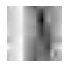

In [ ]:
plot_image(res[0])

## 7) Vérifier numériquement que l'ordre de convergence de ISTA est de l'ordre $O(k^{-1})$ où $k$ est le nombre d'itérations

## 8) Changer la valeur du paramètre $\lambda$ et afficher les images que vous obtenez. Discuter de vos résultats.

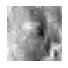

In [ ]:
lambda_l1 = 0.1
y, A = noisy_observations()
res=ista(x0,prox_op_g,grad_f,fun_total,lambda_l1,n_it=100)
plot_image(res[0])

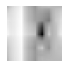

In [ ]:
lambda_l1 = 1.5
y, A = noisy_observations()
res=ista(x0,prox_op_g,grad_f,fun_total,lambda_l1,n_it=100)
plot_image(res[0])

Il apparait qu'on obtient de plus en plus de "détails" en diminuant la valeur de $\lambda_{l1}$. Notons qu'il faudrait une meilleure résolution pour avoir une image raisonnablement discutable.  

# Exercise 3. Complétion de matrice de faible rang

Dans cette section, on s'intéresse au problème de complétion de
matrice. Dans certains problèmes statistiques, on a accès à seulement
certaines entrées d'une matrice $X \in \mathbb{R}^{d \times d}$,
$Y = A \odot X$ où
$A =(\mathbf{1}_{I \times J}((i,j)))_{i,j \in \{1,\ldots,d\}}$, où
$I,J \subset \{1,\ldots,d\}$ et $\odot$ est la multiplication élément
par élément (ou appelé par certains "matlab").  Dans ce problème, on
voudrait alors retrouver les composantes manquantes de $X$. Pour cela,
il est commun de chercher une matrice $X$ de faible rang. Cela revient
alors à chercher à minimiser la fonction $F$ définie sur $\mathbb{R}^{d\times d}$ par
\begin{equation*}
  F(X) = f(X) + \lambda g(X), \qquad f(X) = ||Y-A\odot X||^2_{2}, \, g(X )= ||X||_{\star}  = \sum_{i=1}^d |\sigma_i(X)|,
\end{equation*}
où $||\cdot||_2$ est la norme de Frobenius et
$(\sigma_i)_{i \in \{1,\ldots,d\}}$ sont les valeurs singulières de
$X$. On rappelle le théorème de décomposition en valeurs propres
singulières:

__Théorème 1__
_Soit $A \in \mathbb{R}^{d \times m}$, $d \leq m$. Il existe alors deux matrices orthogonales $O_1,O_2$ et $\sigma_1(A) \geq \cdots \geq \sigma_d(A) \geq 0$ tel que $A = O_1 \Sigma O_2$ où $\Sigma_A \in \mathbb{R}^{d \times m}$ est la matrice dont les entrées sont données par $\Sigma_{i,i} = \sigma_i(A)$ pour $i \in\{1,\ldots,d\}$ et $\Sigma_{i,j} = 0$ sinon.  Les réels $(\sigma_1(A), \ldots, \sigma_d(A))$ sont appelés les valeurs singulières de $A$ et sont les valeurs propres de $A A^T$._


## 1) Montrer que $g$ est la norme dual de la norme opérateur $|||\cdot|||$ sur $\mathbb{R}^{d \times d}$, i. e.
  \begin{equation*}
    g(X) = \sup_{V \in \mathbb{R}^{d \times d}, \, |||V||| \leq 1} \langle X,V\rangle = \sup_{V \in \mathbb{R}^{d \times d}, \, |||V||| \leq 1}\text{Tr}(X^TV),
  \end{equation*}
 où $|||V|||$ est la norme spectral de $V$ (son valeur singulière le plus grand).

 En déduire que $g$ est convexe.


Notons $X=O_1\Sigma_XO_2$ la décomposition en valeurs singulières de $X$.

Soit $V \in \mathbb{R}^{d \times d}, \, |||V||| \leq 1$. Alors d'après l'inégalité de Von Neumann ${Tr}(X^TV)\leq \sum_{i=1}^{d}\sigma_i(X^T)\sigma_i(V)\leq |||V|||\sum_{i=1}^{d}\sigma_i(X)\leq g(X)$. En passant au sup sur $V$, on a $g(X)\geq\sup_{V \in \mathbb{R}^{d \times d}, \, |||V||| \leq 1}\text{Tr}(X^TV)$.

Réciproquement on pose $V=O_1O_2$ alors $|||V||| \leq |||O_1|||\times|||O_2||| \leq 1$ car $O_1$ et $O_2$ sont orthogonales. On a $\text{Tr}(X^TV)=\text{Tr}(O_2^T\Sigma_XO_1^TO_1O_2)=\text{Tr}(O_2^T\Sigma_XO_2)=\text{Tr}(\Sigma_X)=g(X)$. Ainsi, on a le résultat souhaité.


  $g$ est convexe en effet :

  $\forall X, Y, V \in \mathbb{R}^{d \times d}$, et $\forall \lambda \in [0,1],  Tr((\lambda X + (1-\lambda)Y)^TV)= \lambda Tr(X^TV)+ (1-\lambda)Tr(Y^TV) \leq \lambda g(X)+ (1-\lambda)g(Y)$

Par suite, en passant au supremum sur $V$.
$$g(\lambda X + (1-\lambda)Y) \leq \lambda g(X)+ (1-\lambda)g(Y)$$


## On cherche alors à appliquer ISTA pour minimiser $F$

## 2) Générer les données $A$ et $y$ et fixer pour le moment $\lambda$

In [ ]:
lambda_nuclear = 1
Y, A = noisy_observation_nuclear()

## 3) Calculer le gradient de $f$ pour cet exemple

On a $f(X) = ||Y-A\odot X||^2_{2}$ donc :

$\forall (X,H)\in\mathbb{R}^{d\times d}, f(X+H)= ||Y-A\odot X -A\odot H||^2_{2} = ||Y-A\odot X||^2_{2} -2 \langle Y-A\odot X,A\odot H\rangle +||A\odot H||^2_{2} $

Notons $B=Y-A\odot X$. On a $\langle B,A\odot H\rangle=\sum_{i,j}b_{i,j}[A\odot H]_{i,j}=\sum_{i,j}b_{i,j}a_{i,j}h_{i,j}=\langle A\odot B, H\rangle$.

Ainsi $\langle Y-A\odot X,A\odot H\rangle=\langle A\odot(Y-A\odot X),H\rangle$.

Et $\Vert A\odot H\Vert_2=\sqrt{\sum_{i,j}a_{i,j}^2h_{i,j}^2}\leq(\sum_{i,j}a_{i,j}^4)^{\frac{1}{4}}(\sum_{i,j}h_{i,j}^4)^{\frac{1}{4}}\leq C\Vert H\Vert_2$ où $C$ est une constante (on a utilisé implicitement l'équivalence des normes).

On a donc:
$$\nabla f(X)= -2A\odot(Y-A\odot X)$$


## 4) Dans cette question, on s'intéresse au calcul de l'opérateur proximal de $g$

### 4a) En utilisant que la norme de Frobenius est invariant par rotation, montrer que pour tout $X \in \mathbb{R}^{d \times d}$  le problème de minimisation
$$
  \min_{Y \in \mathbb{R}^{d\times d} } ||Y||_{\star} +(2\gamma)^{-1} ||Y-X||^2_2, \qquad\qquad\qquad (1)
$$
est équivalent à
$$
    \min_{D \in \mathsf{E}} ||D||_{\star} +(2\gamma)^{-1} ||D-\Sigma_X||^2_2, \qquad\qquad\qquad (2)
$$
où $\mathsf{E}$ est l'ensemble des matrices diagonales de $\mathbb{R}^{d \times d}$ et $\Sigma_X$ est la matrice diagonale donnée par la décomposition en valeurs singulières de $X$.  Pour cela on utilisera le résultat suivant [2].

__Théorème 2__
_Soit $A,B \in \mathbb{R}^{d \times d}$ deux matrices de dimension $d$. Alors pour toutes matrices orthogonales $O_1,O_2$,
$$
\langle O_1 A O_2,B\rangle \leq \langle\Sigma_A,\Sigma_B\rangle,
$$
où $\Sigma_A$ et $\Sigma_B$ sont les deux matrices diagonales données par la décomposition en valeurs singulières de respectivement $A$ et $B$._

Si $D$ est une solution de (2), comment construire $Y$ solution de (1) ?

Montrons que $(1)\geq (2)$. Soit $Y\in\mathbb{R}^{d\times d}$
$$||Y||_{\star} +(2\gamma)^{-1} ||Y-X||^2_2= ||\Sigma_Y||_{\star} +(2\gamma)^{-1}[ ||Y||^2_2 +||X||^2_2 - 2\langle Y,X\rangle] = ||\Sigma_Y||_{\star} +(2\gamma)^{-1}[ ||O_3\Sigma_YO_4||^2_2 +||O_1\Sigma_YO_2||^2_2 - 2\langle Y,X\rangle] \geq ||\Sigma_Y||_{\star} +(2\gamma)^{-1}[ ||\Sigma_Y||^2_2 +||\Sigma_Y||^2_2 - 2\langle \Sigma_Y,\Sigma_X\rangle]=||\Sigma_Y||_{\star} +(2\gamma)^{-1}||\Sigma_Y-\Sigma_X||^2_2\geq (2)$$

En passant à l'infimum sur $Y$, on a bien: $(1)\geq (2)$.

Montrons que $(2)\geq (1)$. Soit $D\in E$
$$||D||_{\star} +(2\gamma)^{-1} ||D-\Sigma_X||^2_2= ||D||_{\star} +(2\gamma)^{-1}[ ||D||^2_2 +||\Sigma_X||^2_2 - 2\langle D,\Sigma_X\rangle]$$
Or $$
-\langle D , X\rangle \leq \langle\Sigma_{-D},\Sigma_X\rangle=\langle -D,\Sigma_X\rangle=-\langle D,\Sigma_X\rangle,
$$
Donc:
$$||D||_{\star} +(2\gamma)^{-1} ||D-\Sigma_X||^2_2 \geq  ||D||_{\star} +(2\gamma)^{-1}[ ||D||^2_2 +||X||^2_2 - 2\langle D,X\rangle]=||D||_{\star} +(2\gamma)^{-1} ||D-X||^2_2\geq (1)$$

En passant à l'infimum sur $D$, on a bien: $(2)\geq (1)$.

Ainsi les deux problèmes de minimisation sont bien équivalents.

### 4b) En déduire que pour tout $\gamma >0$ et $X \in \mathbb{R}^{d \times d}$
$$
      \text{prox}_g^{\gamma}(X) = U \text{prox}_{\ell_1}^{\gamma}(\Sigma_X) V,
$$
où $X = U \Sigma_X V$ est une décomposition en valeurs singulières
de $X$ et $\text{prox}_{\ell_1}^{\gamma}$ est l'operateur proximal de la
norme $\ell_1$, $Y \mapsto \sum_{i,j=1}^d |Y_{i,j}|$.

on pose $p=U \text{prox}_{\ell_1}^{\gamma}(\Sigma_X) V$

$||p||_* +(2\gamma)^{-1} ||p-X||_2^2= ||\text{prox}_{\ell_1}^{\gamma}(\Sigma_X)||_* +(2\gamma)^{-1} ||\text{prox}_{\ell_1}^{\gamma}(\Sigma_X)-\Sigma_X||_2^2 \geq ||\text{prox}_{g}^{\gamma}||_* +(2\gamma)^{-1} ||\text{prox}_{g}^{\gamma}(X)-X||_2^2$

On sait que les matrices $\text{prox}_{g}^{\gamma}(X)$  est diagonale. et que $||\text{prox}_{g}^{\gamma}(X)||_* \leq \ell_1(\text{prox}_{g}^{\gamma}(X)).$

## 5) Implémenter l'opérateur proximal de $g$

In [ ]:
def prox_op_g_new(X,gamma):
  U,S,V = np.linalg.svd(X)
  prox_l1_S = prox_op_g(S,gamma)
  prox_l1_sigma = np.diag(prox_l1_S)
  return( np.dot( U , np.dot( prox_l1_sigma , V ) ) )


## 6) Tester l'algorithme ISTA et illustrer graphiquement sa convergence

In [ ]:
def grad_f_new(X):
  grad_f = -2*np.multiply( A , Y - np.multiply( A , X ) )
  L = np.linalg.norm( -2*np.multiply( A , A) )
  return( np.array([grad_f,L]) )

In [ ]:
def fun_total_new(X,lambda_l):
  U,S,V = np.linalg.svd(X)
  f_X=np.linalg.norm(np.dot( A, X ) - Y)
  g_X=np.linalg.norm(S,1)

In [ ]:
X0=np.zeros(A.shape)
res=ista(X0,prox_op_g_new,grad_f_new,fun_total_new,lambda_nuclear,n_it=100)

In [ ]:
print({'X_fin=':res[0]})

{'X_fin=': array([[ 9.88346280e-16,  9.07116582e-17, -3.08268632e-17,
        -5.09288943e-16,  2.28978573e-16,  3.68382523e-16,
         7.05467855e-16, -2.14504737e-16,  6.46446609e-01,
         8.57492428e-16,  5.37661192e-16,  2.46850898e-33,
         2.22660848e-15,  2.76132827e-16,  1.18003183e-15,
         0.00000000e+00],
       [-3.68529620e-16, -7.73930909e-16, -2.08225274e-16,
        -6.82849248e-16, -6.72396315e-16,  7.97064649e-16,
         5.05080556e-16,  2.71000172e-16,  3.56834659e-15,
         9.61573781e-16, -8.68060783e-16,  1.84257501e-18,
         5.00000000e-01, -4.92953264e-17,  3.71443505e-16,
         0.00000000e+00],
       [ 1.38713723e-16,  2.33997897e-01,  7.22334925e-16,
         7.98537860e-01,  2.01959285e-02,  7.80703230e-01,
         4.39240617e-01,  4.28534705e-16, -2.83408146e-16,
         3.86951568e-01, -4.57188418e-02,  1.66383836e-31,
        -1.26511452e-16,  3.14970010e-01,  1.49372673e-16,
         0.00000000e+00],
       [ 1.19178881e-16,  

# Références

[1] Amir Beck and Marc Teboulle. A fast iterative shrinkage-thresholding algorithm for
linear inverse problems. SIAM journal on imaging sciences, 2(1) :183–202, 2009.

[2] J. von Neumann, Some matrix-inequalities and metrization of matric-space,
Tomsk Univ. Rev, 1(11) :286--300, 1937.  